# Clustering

In [1]:
%%capture
import random, math
import import_ipynb
from ml_tools import *
from gradient_descent_and_data_tools import *

### k-Means

k-means clustering is a tool that identifies clusters in your data.  By iterating through with a set number of clusters to fit, k, the clusters are identified by their means.  Later points will be assigned to points based their location within the data cloud.  Clusters are found by intializing with random k points in the d-dimensional space and then iteratively assigning each point to the closest mean, reassign points to the new means and then recomputing the means.  When points are no longer reassigned after recomputation of the means based off the new cluster assignments, the clusters are considered discovered.  The number of clusters in the data and the corresponding k hyperparameter are found by stepping through k-space and finding the "knee" where the total sum of squares slows in its improvement.  

In [2]:
class KMeans:
    '''performs k-means clustering'''
    
    def __init__(self, k):
        self.k = k         # number of clusters
        self.means = None  # means of clusters
        
    def classify(self, input):
        '''return the index of the cluster closest to the input'''
        return min(range(self.k),
                  key = lambda i: squared_distance(input, self.means[i]))
    
    def train(self, inputs):
        # choose k random points as the initial means
        
        self.means = random.sample(inputs, self.k)
        assignments = None
        
        while True:
            # find new assignments
            new_assignments = list(map(self.classify, inputs))
            
            if assignments == new_assignments:
                return
            
            # otherwise keep the new assignments
            assignments = new_assignments
            
            # and compute new means based on new assignemtns
            for i in range(self.k):
                # find all points assigned to cluster i
                i_points = [p for p, a in zip(inputs, assignments) if a ==i]
                
                # check list is not empty
                if i_points:       
                    self.means[i] = vector_mean(i_points)

In [3]:
inputs = [[-14,-5],[13,13],[20,23],[-19,-11],[-9,-16],[21,27],[-49,15],[26,13],[-46,5],[-34,-1],[11,15],[-49,0],[-22,-16],[19,28],[-12,-8],[-13,-19],[-41,8],[-11,-6],[-25,-9],[-18,-3]]


In [4]:
random.seed(0)
clusterer = KMeans(3)
clusterer.train(inputs)
print("3-means:")
print(clusterer.means)
print()

random.seed(0)
clusterer = KMeans(2)
clusterer.train(inputs)
print("2-means:")
print(clusterer.means)
print()

3-means:
[[-25.857142857142854, -4.714285714285714], [20.0, 26.0], [16.666666666666664, 13.666666666666666]]

2-means:
[[-25.857142857142854, -4.714285714285714], [18.333333333333332, 19.833333333333332]]



In [5]:
def squared_clustering_errors(inputs, k):
    """finds the total squared error from k-means clustering the inputs"""
    clusterer = KMeans(k)
    clusterer.train(inputs)
    means = clusterer.means
    assignments = list(map(clusterer.classify, inputs))

    return sum(squared_distance(input,means[cluster])
               for input, cluster in zip(inputs, assignments))


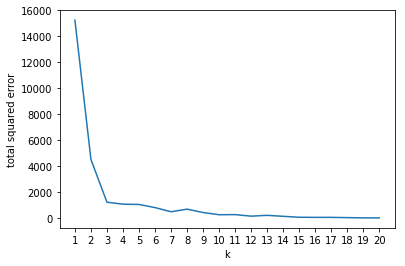

In [6]:
ks = range(1, len(inputs) + 1)
errors = [squared_clustering_errors(inputs, k) for k in ks]

plt.plot(ks, errors)
plt.xticks(ks)
plt.xlabel("k")
plt.ylabel("total squared error")
plt.show()

### Bottom-up Heirarchical Clustering

Rather than identify clusters by finding their "locations" like in k-means, bottom-up heirarchical clustering seeks to identify clusters of points by growing the clusters based off the proximity of points.  These agglomerative clustering approach can also be visualized as a dendrogram.

values live in leaf clusters in the form of 1-tuples:

leaf1 = ([10, 20],)   # need trailing comma

leaf2 = ([30, 15],)   # so Python doesn't treat parentheses as parentheses

and grow as merged clusters represended as 2-tuples:

merged = (1, [leaf1, leaf2])

In [7]:
def is_leaf(cluster):
    '''a cluster is a leaf if it has length 1'''
    return len(cluster) == 1

def get_children(cluster):
    '''returns two children if the cluster is a merged cluster, raises exception for leaf'''
    if is_leaf(cluster):
        raise TypeError('a leaf cluster has no children')
    else:
        return cluster[1]
    
def get_values(cluster):
    '''returns the calue of this cluster if it is a leaf cluster
    or all values in the leaf clusters below if it is not'''
    if is_leaf(cluster):
        return cluster
    else:
        return [value
               for child in get_children(cluster)
               for value in get_values(child)]

To merge clusters use the minimum distance between elements of the two clusters to merge the closest to touching.  To get tight spherical clusters, use maximum distance.

In [8]:
def cluster_distance(cluster1, cluster2, distance_agg=min):
    '''compute pairwise distances between cluster 1 and 2'''
    return distance_agg([distance(input1, input2)
                        for input1 in get_values(cluster1)
                        for input2 in get_values(cluster2)])

In [9]:
def get_merge_order(cluster):
    if is_leaf(cluster):
        return float('inf')
    else:
        return cluster[0]   # merge_order is first element of 2-tuple

In [10]:
def bottom_up_cluster(inputs, distance_agg=min):
    
    # start with every input a leaf cluster
    clusters = [(input,) for input in inputs]
    
    while len(clusters) > 1:
        # find the two closest clsuters
        c1, c2 = min([(cluster1, cluster2)
                     for i, cluster1 in enumerate(clusters)
                     for cluster2 in clusters[:i]],
                    key=lambda p: cluster_distance(p[0], p[1], distance_agg))
        
        # remove them from the list of clusters
        clusters = [c for c in clusters if c != c1 and c != c2]
        
        # merge them, using merge_order as number of clusters left
        merged_cluster = (len(clusters), [c1, c2])
        
        # and add their merge
        clusters.append(merged_cluster)
        
    # return single, final cluster
    return clusters[0]

In [11]:
base_cluster = bottom_up_cluster(inputs)

In [12]:
print(base_cluster)

(0, [(1, [(3, [(14, [(18, [([19, 28],), ([21, 27],)]), ([20, 23],)]), ([26, 13],)]), (16, [([11, 15],), ([13, 13],)])]), (2, [(4, [(5, [(9, [(11, [([-49, 0],), ([-46, 5],)]), ([-41, 8],)]), ([-49, 15],)]), ([-34, -1],)]), (6, [(7, [(8, [(10, [([-22, -16],), ([-19, -11],)]), ([-25, -9],)]), (13, [(15, [(17, [([-11, -6],), ([-12, -8],)]), ([-14, -5],)]), ([-18, -3],)])]), (12, [([-13, -19],), ([-9, -16],)])])])])


In [13]:
def generate_clusters(base_cluster, num_clusters):
    # start with a list with just the base cluster
    clusters = [base_cluster]

    # as long as we don't have enough clusters yet...
    while len(clusters) < num_clusters:
        # choose the last-merged of our clusters
        next_cluster = min(clusters, key=get_merge_order)
        # remove it from the list
        clusters = [c for c in clusters if c != next_cluster]
        # and add its children to the list (i.e., unmerge it)
        clusters.extend(get_children(next_cluster))

    # once we have enough clusters...
    return clusters

In [14]:
print("three clusters, min:")
for cluster in generate_clusters(base_cluster, 3):
    print(get_values(cluster))

print()
print("three clusters, max:")
base_cluster = bottom_up_cluster(inputs, min)
for cluster in generate_clusters(base_cluster, 3):
    print(get_values(cluster))

three clusters, min:
[[-49, 0], [-46, 5], [-41, 8], [-49, 15], [-34, -1], [-22, -16], [-19, -11], [-25, -9], [-11, -6], [-12, -8], [-14, -5], [-18, -3], [-13, -19], [-9, -16]]
[[19, 28], [21, 27], [20, 23], [26, 13]]
[[11, 15], [13, 13]]

three clusters, max:
[[-49, 0], [-46, 5], [-41, 8], [-49, 15], [-34, -1], [-22, -16], [-19, -11], [-25, -9], [-11, -6], [-12, -8], [-14, -5], [-18, -3], [-13, -19], [-9, -16]]
[[19, 28], [21, 27], [20, 23], [26, 13]]
[[11, 15], [13, 13]]


In [15]:
three_clusters = [get_values(cluster) for cluster in generate_clusters(base_cluster, 3)]

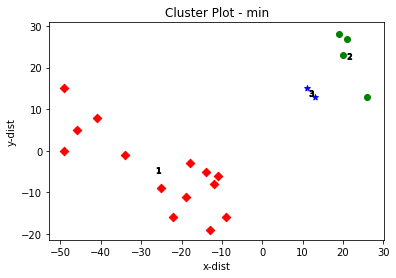

In [16]:
for i, cluster, marker, color in zip([1,2,3],
                                    three_clusters,
                                    ['D', 'o', '*'],
                                    ['r', 'g', 'b']):
    xs, ys = zip(*cluster)
    plt.scatter(xs, ys, color=color, marker=marker)
    x, y = vector_mean(cluster)
    plt.plot(x, y, marker='$'+str(i)+'$', color='k')
plt.title('Cluster Plot - min')
plt.xlabel('x-dist')
plt.ylabel('y-dist')
plt.show()

In [17]:
print("three clusters, max:")
for cluster in generate_clusters(base_cluster, 3):
    print(get_values(cluster))

print()
print("three clusters, max:")
base_cluster = bottom_up_cluster(inputs, max)
for cluster in generate_clusters(base_cluster, 3):
    print(get_values(cluster))

three clusters, max:
[[-49, 0], [-46, 5], [-41, 8], [-49, 15], [-34, -1], [-22, -16], [-19, -11], [-25, -9], [-11, -6], [-12, -8], [-14, -5], [-18, -3], [-13, -19], [-9, -16]]
[[19, 28], [21, 27], [20, 23], [26, 13]]
[[11, 15], [13, 13]]

three clusters, max:
[[11, 15], [13, 13], [26, 13], [19, 28], [21, 27], [20, 23]]
[[-41, 8], [-49, 15], [-49, 0], [-46, 5], [-34, -1]]
[[-11, -6], [-12, -8], [-14, -5], [-18, -3], [-22, -16], [-19, -11], [-25, -9], [-13, -19], [-9, -16]]


In [18]:
three_clusters = [get_values(cluster) for cluster in generate_clusters(base_cluster, 3)]

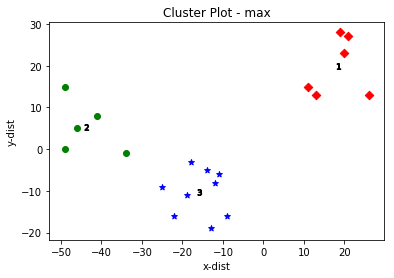

In [19]:
for i, cluster, marker, color in zip([1,2,3],
                                    three_clusters,
                                    ['D', 'o', '*'],
                                    ['r', 'g', 'b']):
    xs, ys = zip(*cluster)
    plt.scatter(xs, ys, color=color, marker=marker)
    x, y = vector_mean(cluster)
    plt.plot(x, y, marker='$'+str(i)+'$', color='k')
plt.title('Cluster Plot - max')
plt.xlabel('x-dist')
plt.ylabel('y-dist')
plt.show()